In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import subprocess
import time
import os

In [2]:
import re

def replacer(mod, num):
    # mod is 'cpp' or 'hs'
    num = str(num)
    with open(f'main.{mod}', encoding='utf8') as f_inp:
        data = f_inp.read()
    if mod == 'cpp' or mod == 'grf':
        data = re.sub(r'(?<=Is_prime\()\d+', num, data)
    elif mod == 'hs':
        data = re.sub(r'(?<=is_prime )\d+', num, data)
    with open(f'main.{mod}', 'w', encoding='utf8') as f_out:
        f_out.write(data)

In [3]:
def get_prime():
    num = 2
    while True:
        i = 2
        prime = True
        while i*i <= num:
            if num % i == 0:
                prime = False
                break
            i += 1
        if prime:
            yield num
        num += 1

In [4]:
# package_path = "/home/dmitry/IT/Sem7/GRF_emulator"

# def cpp_counter(numbers, limit):
#     global df_dict
#     df_dict['cpp'] = []
#     df_dict['cpp+comp'] = []
#     flag_break = False
#     for num in numbers:
#         if flag_break:
#             df_dict['cpp'].append(None)
#             df_dict['cpp+comp'].append(None)
#             continue
#         replacer('cpp', num)
#         compilation_start = time.perf_counter()
#         subprocess.call("g++ -O2 -o main.out main.cpp".split())
#         exec_start = time.perf_counter()
#         cpp_comp_time = exec_start - compilation_start
#         subprocess.call("./main.out")
#         finish = time.perf_counter()
#         df_dict['cpp'].append(finish - exec_start)
#         df_dict['cpp+comp'].append(finish - exec_start + cpp_comp_time)
#         if finish - exec_start + cpp_comp_time > limit:
#             flag_break = True

# def haskell_counter(numbers, name, optimizations, limit):
#     global df_dict
#     df_dict['hs'] = []
#     df_dict['hs+comp'] = []
#     flags = " ".join(optimizations)
#     flag_break = False
#     for num in numbers:
#         if flag_break:
#             df_dict['hs'].append(None)
#             df_dict['hs+comp'].append(None)
#             continue
#         replacer('hs', num)
#         compilation_start = time.perf_counter()
#         subprocess.call(f"ghc {flags} -o main.out main.hs".split())
#         exec_start = time.perf_counter()
#         hs_comp_time = exec_start - compilation_start
#         subprocess.call("./main.out")
#         finish = time.perf_counter()
#         df_dict['hs'].append(finish - exec_start)
#         df_dict['hs+comp'].append(finish - exec_start + hs_comp_time)
#         if finish - exec_start + hs_comp_time > limit:
#             flag_break = True


# def python_counter(numbers, name, optimizations, limit):
#     global df_dict
#     df_dict[name] = []
#     flags = " ".join(optimizations)
#     flag_break = False
#     for num in numbers:
#         if flag_break:
#             df_dict[name].append(None)
#             continue
#         replacer('grf', num)
#         os.chdir('/home/dmitry/Sem8/GRF_emulator')
#         exec_start = time.perf_counter()
#         subprocess.call(f'python -m grfemulator.core {flags} experiments/main.grf'.split())
#         finish = time.perf_counter()
#         os.chdir('/home/dmitry/Sem8/GRF_emulator/experiments')
#         df_dict[name].append(finish - exec_start)
#         if finish - exec_start > limit:
#             flag_break = True


# def accurate_python_counter(numbers, name, optimizations, limit, accuracy):
#     global df_dict
#     for i in range(accuracy):
#         python_counter(numbers, f'{name}{i}', optimizations, limit)
#     df_dict[name] = [sum([df_dict[f'{name}{i}'][ind] for i in range(accuracy)]) / accuracy for ind in range(len(df_dict['number']))]
#     for i in range(accuracy):
#         del df_dict[f'{name}{i}']

def program_counter(mode, name, numbers, limit, optimizations=[]):
    """
    mode - 'grf', 'hs', 'cpp'
    """
    global df_dict
    df_dict[name] = []
    if mode == 'hs' or mode == 'cpp':
        df_dict[name + '+comp'] = []
    flags = " ".join(optimizations)
    flag_break = False
    for num in numbers:
        if flag_break:
            df_dict[name].append(None)
            if mode == 'hs' or mode == 'cpp':
                df_dict[name + '+comp'].append(None)
            continue
        replacer(mode, num)
        match mode:
            case 'grf':
                os.chdir('/home/dmitry/Sem8/GRF_emulator')
                exec_start = time.perf_counter()
                comp_time = 0
                subprocess.call(f'python -m grfemulator.core {flags} experiments/main.grf'.split())
                finish = time.perf_counter()
                os.chdir('/home/dmitry/Sem8/GRF_emulator/experiments')
            case 'hs':
                compilation_start = time.perf_counter()
                subprocess.call(f"ghc {flags} -o main.out main.hs".split())
                exec_start = time.perf_counter()
                comp_time = exec_start - compilation_start
                subprocess.call("./main.out")
                finish = time.perf_counter()
            case 'cpp':
                compilation_start = time.perf_counter()
                subprocess.call(f"g++ {flags} -o main.out main.cpp".split())
                exec_start = time.perf_counter()
                cpp_comp_time = exec_start - compilation_start
                subprocess.call("./main.out")
                finish = time.perf_counter()
        df_dict[name].append(finish - exec_start)
        if mode == 'hs' or mode == 'cpp':
            df_dict[name + '+comp'].append(finish - exec_start + comp_time)
        if finish - exec_start + comp_time > limit:
            flag_break = True

def accurate_counter(mode, name, numbers, limit, accuracy, optimizations=[]):
    global df_dict
    df_dict[name] = []
    for i in range(accuracy):
        program_counter(mode, f'{name}{i}', numbers, limit, optimizations)
    for ind in range(len(df_dict['number'])):
        nums = [df_dict[f'{name}{i}'][ind] for i in range(accuracy)]
        if None in nums:
            df_dict[name].append(None)
        else:
            df_dict[name].append(sum(nums) / accuracy)
    for i in range(accuracy):
        del df_dict[f'{name}{i}']


df_dict = {'number': [i[0] for i in zip(get_prime(), range(30))]}
os.chdir('/home/dmitry/Sem8/GRF_emulator/experiments')

In [5]:
os.chdir('/home/dmitry/Sem8/GRF_emulator/experiments')
limit = 10
accuracy = 3
# cpp_counter(df_dict['number'], limit)
# program_counter('hs', 'hs_O0', df_dict['number'], limit, optimizations=['-O0'])
# program_counter('hs', 'hs_O2', df_dict['number'], limit, optimizations=['-O2'])
# program_counter('grf', 'py', df_dict['number'], limit, optimizations=[])
# program_counter('grf', 'py_rec_to_for', df_dict['number'], limit, optimizations=["--Orec-to-for"])
# program_counter('grf', 'py_opport', df_dict['number'], limit, optimizations=["--Oopportunistic"])



accurate_counter('grf', 'py', df_dict['number'], limit, accuracy, optimizations=[])
accurate_counter('grf', 'py_rec_to_for', df_dict['number'], limit, accuracy, optimizations=["--Orec-to-for"])
accurate_counter('grf', 'py_opport', df_dict['number'], limit, accuracy, optimizations=["--Oopportunistic"])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [6]:
[(key, len(val)) for key, val in df_dict.items()]

[('number', 30), ('py0', 30), ('py1', 30), ('py2', 30)]

In [21]:
for i in range(5):
    for j in range(3):
        del df_dict[f"hs_O{i}{j}+comp"]

In [6]:
# program_counter('hs', 'hs_O0', df_dict['number'], limit, optimizations=['-O0'])
# program_counter('hs', 'hs_O1', df_dict['number'], limit, optimizations=['-O1'])
# program_counter('hs', 'hs_O2', df_dict['number'], limit, optimizations=['-O2'])
# program_counter('hs', 'hs_O3', df_dict['number'], limit, optimizations=['-O3'])
# program_counter('hs', 'hs_O4', df_dict['number'], limit, optimizations=['-O4'])

accurate_counter('hs', 'hs_O0', df_dict['number'], limit, accuracy, optimizations=['-O0'])
accurate_counter('hs', 'hs_O1', df_dict['number'], limit, accuracy, optimizations=['-O1'])
accurate_counter('hs', 'hs_O2', df_dict['number'], limit, accuracy, optimizations=['-O2'])
accurate_counter('hs', 'hs_O3', df_dict['number'], limit, accuracy, optimizations=['-O3'])
accurate_counter('hs', 'hs_O4', df_dict['number'], limit, accuracy, optimizations=['-O4'])

[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2]

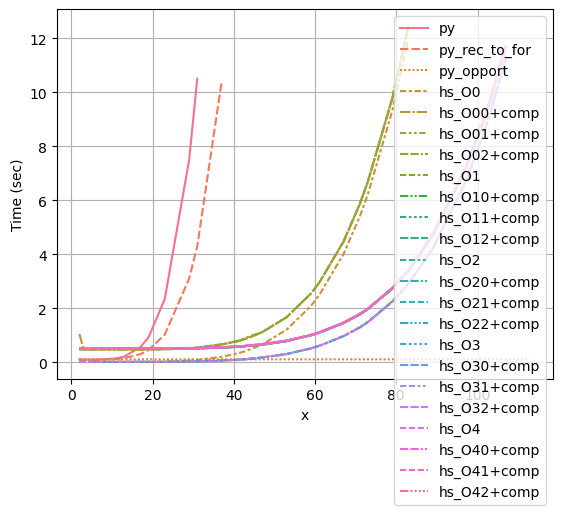

In [7]:
df = pd.DataFrame(df_dict).set_index('number')
sns.lineplot(data=df)
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()
# plt.savefig("small_results.png", dpi=300)

In [8]:
print(df_dict)

{'number': [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113], 'py': [0.10495750264575084, 0.09181376368117829, 0.0927904670049126, 0.09498619969235733, 0.14031545065032938, 0.20517778534364575, 0.5582182816579007, 0.9173477506653095, 2.337415315657078, 7.488522744989798, 10.4965185506735, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], 'py_rec_to_for': [0.0914297533260348, 0.08975227896977837, 0.09290286968462169, 0.09319871365247916, 0.11700096701194222, 0.14536907098954543, 0.2962170340081987, 0.44570467465867597, 1.022886284335982, 3.0931141586625017, 4.29162856998543, 10.382917860309439, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], 'py_opport': [0.10452795267337933, 0.1042647230012032, 0.10510323701115946, 0.10524044701984774, 0.10513481633582462, 0.10538912300641338, 0.104061912997

In [9]:
df_dict.keys()

dict_keys(['number', 'py', 'py_rec_to_for', 'py_opport', 'hs_O0', 'hs_O00+comp', 'hs_O01+comp', 'hs_O02+comp', 'hs_O1', 'hs_O10+comp', 'hs_O11+comp', 'hs_O12+comp', 'hs_O2', 'hs_O20+comp', 'hs_O21+comp', 'hs_O22+comp', 'hs_O3', 'hs_O30+comp', 'hs_O31+comp', 'hs_O32+comp', 'hs_O4', 'hs_O40+comp', 'hs_O41+comp', 'hs_O42+comp'])

In [10]:
ru_df_dict = {}
pair_list = [
    ('number', 'number'),
    ('Без оптимизаций', 'py'),
    ('Рекурсия в цикл', 'py_rec_to_for'),
    ('Оппортунистическая', 'py_opport'),
    ('Haskell O0', 'hs_O0'),
    ('Haskell O1', 'hs_O1'),
    ('Haskell O2', 'hs_O2'),
    ('Haskell O3', 'hs_O3'),
    ('Haskell O4', 'hs_O4'),
]
for ru_key, key in pair_list:
    ru_df_dict[ru_key] = df_dict[key]

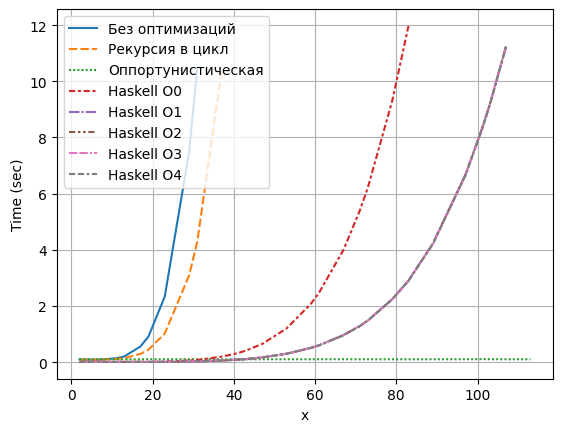

In [12]:
ru_df = pd.DataFrame(ru_df_dict).set_index('number')
sns.lineplot(data=ru_df)
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()
plt.savefig("ru_medium_results.png", dpi=300)

In [ ]:
# del df_dict['hs']
# del df_dict['hs+comp']
# del df_dict['python_opportunistic']
# python_counter(df_dict['number'], 'python_opt', ["--Orec-to-for"], limit)
# df = pd.DataFrame(df_dict).set_index('number')
# sns.lineplot(data=df)
# plt.xlabel('x')
# plt.ylabel('Time (sec)')
# plt.grid()

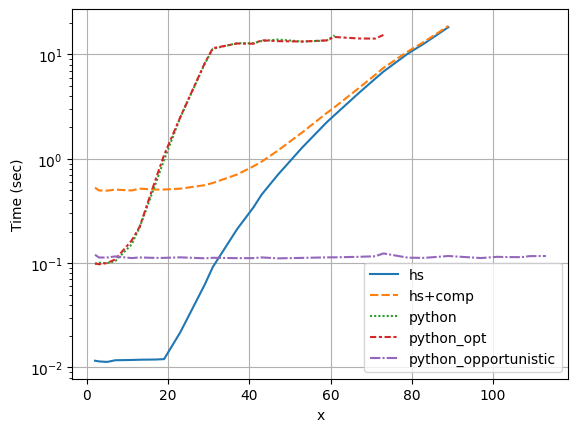

In [45]:
df = pd.DataFrame(df_dict).set_index('number')
sns.lineplot(data=df)
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()
plt.yscale('log')

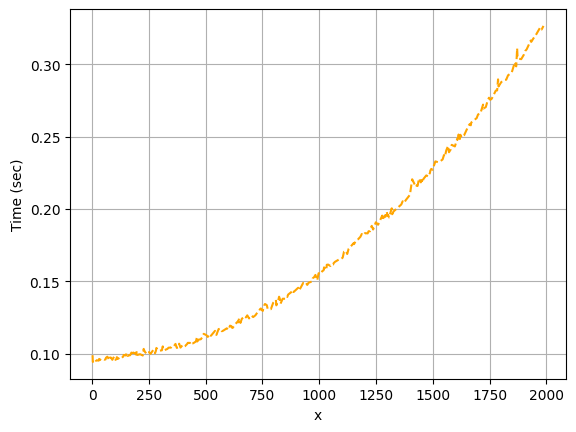

In [97]:
# df = pd.DataFrame(df_dict).set_index('number')
plt.plot(df_dict['number'], df_dict['python_opportunistic_opt'], '--', color='orange')
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()

In [15]:
print(df_dict['cpp'])
print(df_dict['cpp+comp'])

[0.000620104001427535, 0.0006506669960799627, 0.0006212070002220571, 0.000849304000439588, 0.08750554099970032, 1.1900670450049802, 1478.6221969519975, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[0.16517295000085142, 0.16877759699855233, 0.16849413399904734, 0.17160637400229461, 0.25651061499956995, 1.3535347800061572, 1478.7915705580017, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
